## Exploring Rossmann Drug Store Sales Data

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (16.0, 8.0)


data = pd.read_csv('./assets/datasets/rossmann.csv', skipinitialspace=True, low_memory=False)
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [3]:
data['2015-05'];

In [4]:
store1_data = data[data.Store == 1]

In [5]:
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

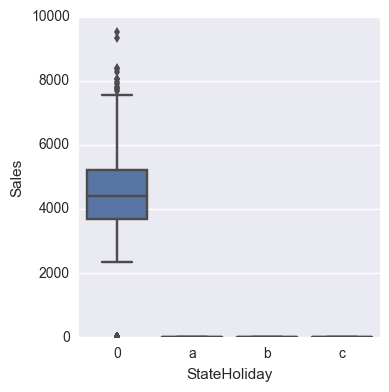

In [6]:
import seaborn as sns
%matplotlib inline

sns.factorplot(x='StateHoliday',y ='Sales', data = store1_data, kind='box')


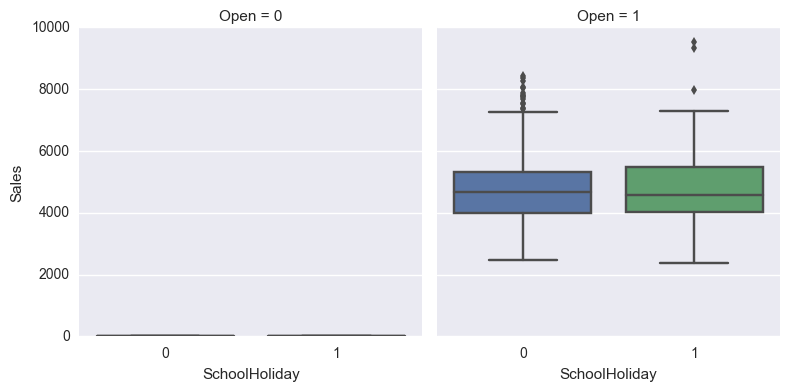

In [7]:
# Can we separate school and state holidays?
# Try separating out days the stores are closed.
sns.factorplot(
    col='Open',
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

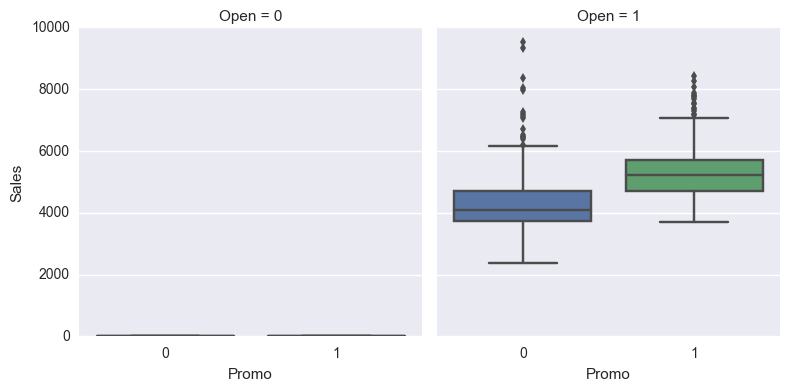

In [8]:
# What happens to sales on promotion days?

sns.factorplot(col = 'Open', x = 'Promo', y = 'Sales', data=store1_data, kind='box')

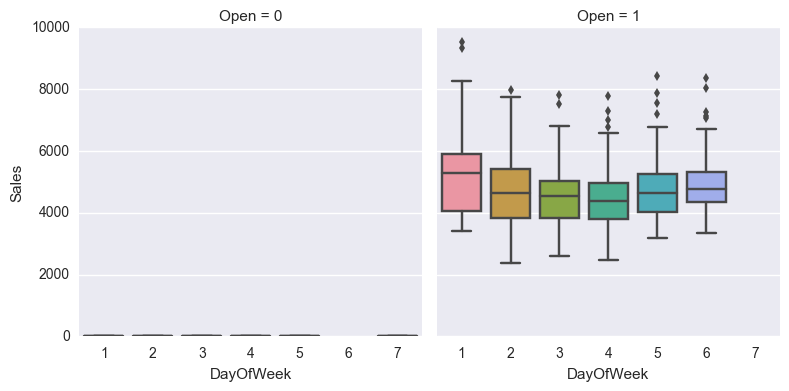

In [9]:
# How about across days of the week?

sns.factorplot(col='Open',x = 'DayOfWeek',y= 'Sales', data = store1_data, kind='box')

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

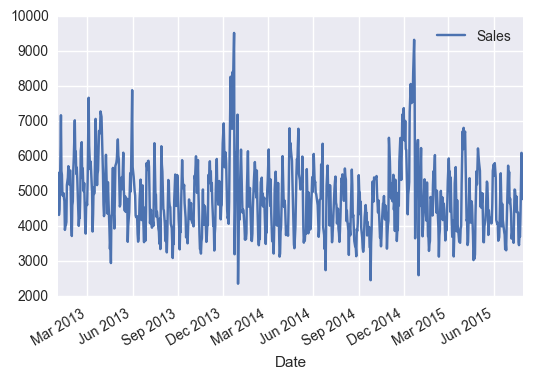

In [10]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data['Open']==1]
store1_open_data[['Sales']].plot()

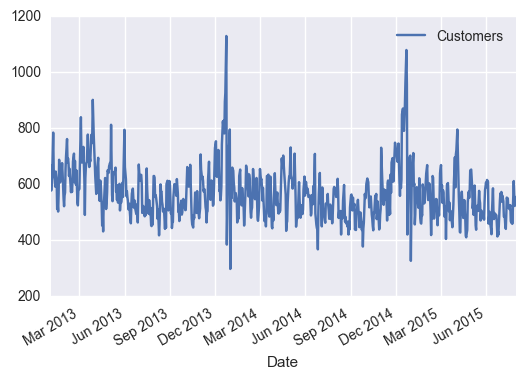

In [11]:
store1_open_data[['Customers']].plot()

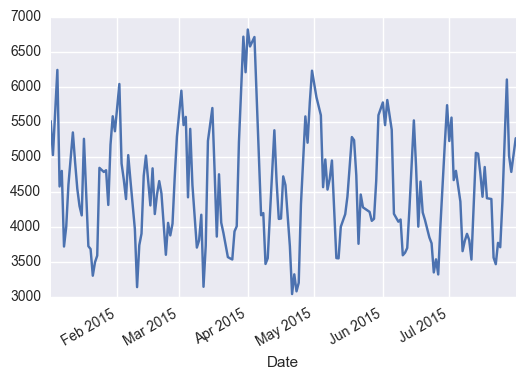

In [12]:
# Let's zoom in on 2015 with index filtering

store1_data_2015 = store1_data['2015']
store1_data_2015[store1_data_2015['Open']==1]['Sales'].plot()

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10, computes the correlation between every point and the point 10 days earlier.

In [13]:
data['Sales'].resample('D',how='mean').autocorr(lag=7)

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


0.55748935887396067

In [14]:
data['Sales'].resample('D',how='mean').autocorr(lag=1)

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


-0.025858276006383588

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  We want to know what the mean and median sales were for each month and year.

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [15]:
data[['Sales']].resample('M', how=['median', 'mean']).head()

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  if __name__ == '__main__':


Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

While identifying the monthly averages are useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [16]:
# Resample to have the daily average over all stores
daily_store_sales = data[['Sales']].resample('D',how='sum')
pd.rolling_mean(daily_store_sales, window = 10, center=True).head(15)

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app
/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  app.launch_new_instance()


,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
2013-01-06,6120370.8
2013-01-07,6914577.9
2013-01-08,6821344.1
2013-01-09,6200967.3


`rolling_mean` (as well as `rolling_median`) takes these parameters:
    - the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  if __name__ == '__main__':


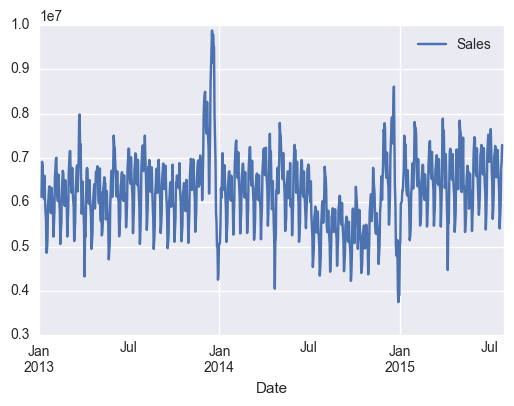

In [17]:
pd.rolling_mean(daily_store_sales, window=10, center=True).plot()

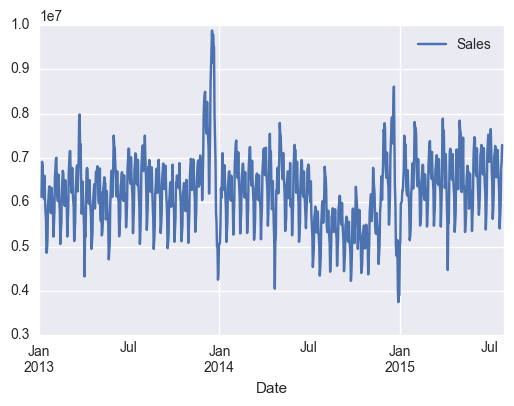

In [18]:
# undeprecated

daily_store_sales.rolling(window=10,center=True).mean().plot()

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many prior rows to use for the difference.


In [19]:
daily_store_sales.head()

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


In [20]:
daily_store_sales.diff(periods=1).head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,6852594.0
2013-01-03,-602009.0
2013-01-04,291134.0
2013-01-05,-687361.0


In [21]:
daily_store_sales.diff(periods=2).head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,6250585.0
2013-01-04,-310875.0
2013-01-05,-396227.0


### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [22]:
# computes the average sales, from the first date _until_ the date specified.
pd.expanding_mean(daily_store_sales).head()

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.expanding(min_periods=1).mean()
  from ipykernel import kernelapp as app


,Sales
Date,
2013-01-01,9.723500e+04
2013-01-02,3.523532e+06
2013-01-03,4.464961e+06
2013-01-04,5.008460e+06
2013-01-05,5.197086e+06


## Independent practice

> Plot the distribution of sales by month and compare the effect of promotions

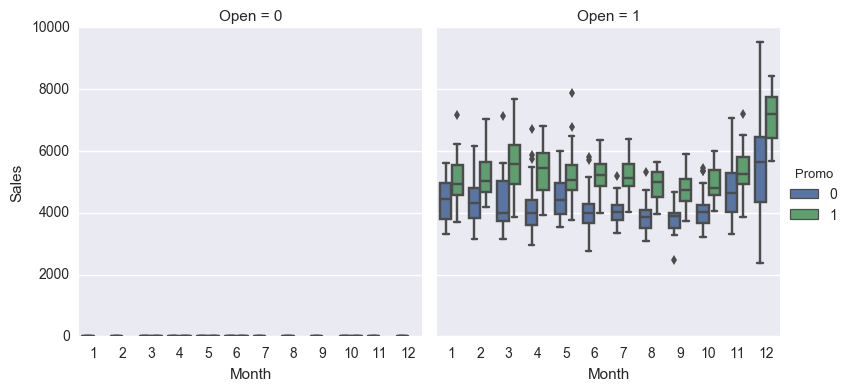

In [31]:
sns.factorplot(col='Open', x = 'Month', y = 'Sales', hue='Promo',data = store1_data, kind='box')

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [26]:
avg_day_sales = data[['Sales']].resample('D').mean()

In [27]:
# correlated with prior date
avg_day_sales['Sales'].autocorr(lag=1)

-0.025858276006383588

In [32]:
# correlated with similar date last month
print avg_day_sales['Sales'].autocorr(lag=31)
print avg_day_sales['Sales'].autocorr(lag=30)
print avg_day_sales['Sales'].autocorr(lag=29)
print avg_day_sales['Sales'].autocorr(lag=28)

-0.0490079878461
-0.129842458225
-0.0925389934415
0.718112116053


In [34]:
# correlated with similar date last year
print avg_day_sales['Sales'].autocorr(lag=365)
print avg_day_sales['Sales'].autocorr(lag=364)

0.0202385294483
0.756613221965


> Plot the 15 day rolling mean of customers in the stores

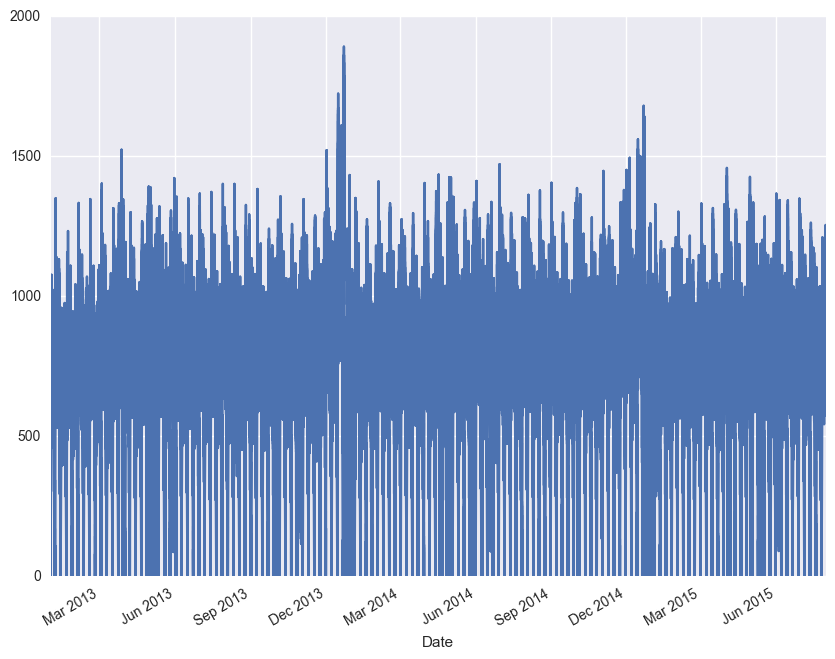

In [83]:
data['Customers'].rolling(window=15,center=True).mean().plot(figsize=(10,8))

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=True).mean()
  if __name__ == '__main__':


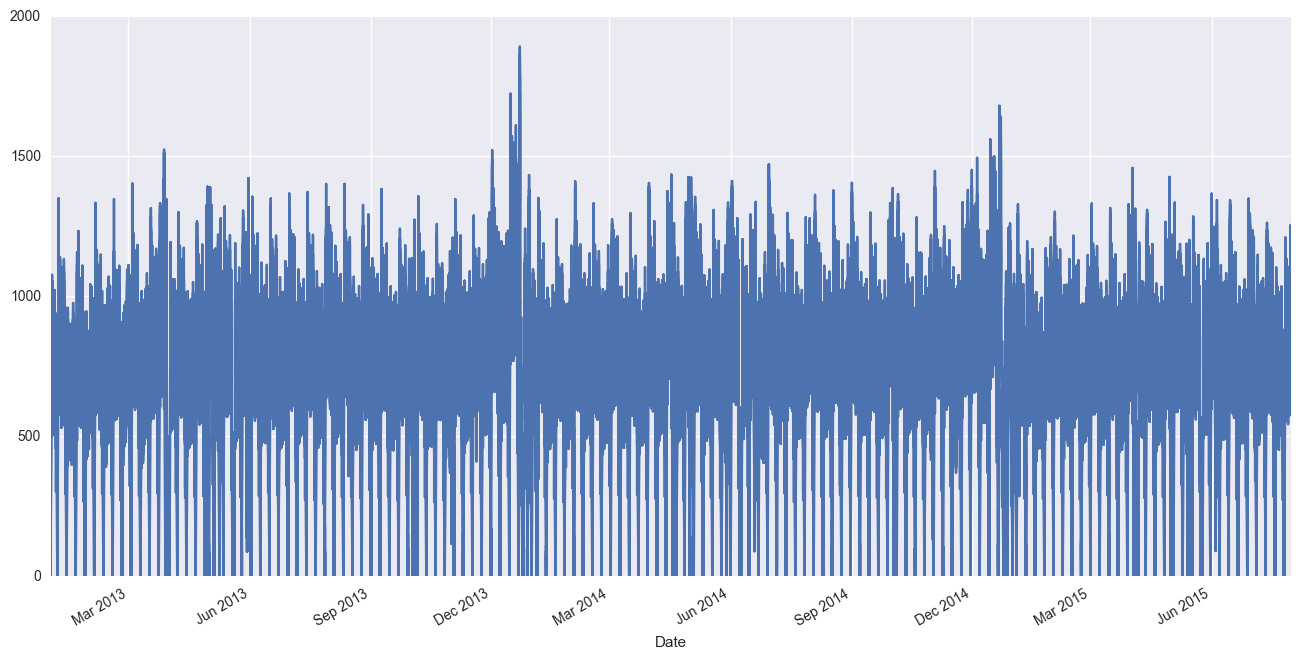

In [79]:
pd.rolling_mean(data['Customers'], window=15, center=True).plot(figsize=(16,8))

> Identify the date with largest drop in average sales from the same date in the previous month

In [35]:
avg_day_sales = data[['Sales']].resample('D').mean()
avg_day_sales['Open'] = data[['Open']]
avg_day_sales['Diff_Month'] = avg_day_sales[['Sales']].diff(periods=28)

In [36]:
avg_day_sales.sort_values(by='Diff_Month').head()

,Sales,Diff_Month
Date,,
2013-04-01,216.211659,-9714.444843
2014-12-26,219.505882,-9590.891979
2015-05-25,268.585650,-9243.073543
2014-01-01,105.926457,-9045.526457
2015-01-01,116.737220,-9031.970802


> Compute the total sales up until Dec. 2014

In [119]:
total_daily_sales = data[['Sales']].resample('D').sum()
pd.expanding_sum(total_daily_sales)['2014-12'].head()

/Users/andrewjeong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


,Sales
Date,
2014-12-01,4.291837e+09
2014-12-02,4.300681e+09
2014-12-03,4.308939e+09
2014-12-04,4.317493e+09
2014-12-05,4.327295e+09


> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`

In [125]:
total_daily_sales.rolling(window=15,center=False).mean().diff(1).sort_values(by ='Sales').head()

,Sales
Date,
2014-01-01,-862392.333333
2013-12-31,-739245.600000
2014-01-05,-665364.066667
2014-05-01,-652451.533333
2015-01-01,-623548.266667
